<a href="https://colab.research.google.com/github/NRmethun/ML-DL-Notebook/blob/main/mobile_net_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pickle
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.applications.mobilenet import MobileNet
from keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D
import os.path
import fnmatch
import itertools
import functools
from keras.models import Model

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
IMAGE_SIZE =[300,300]
train_data_dir = '/content/drive/MyDrive/Carrot_synthetic_data/Train'
validation_data_dir = '/content/drive/MyDrive/Carrot_synthetic_data/Validation'


train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 20
image_size = 0
width=300
height=300
depth=3

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(height, width),
    batch_size=BS,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(height, width),
    batch_size=BS,
    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(height, width),
    batch_size=BS,
    class_mode='categorical',
    shuffle = False)

Found 2131 images belonging to 6 classes.
Found 296 images belonging to 6 classes.
Found 296 images belonging to 6 classes.


In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False )
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(1024,activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(6, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.n // BS,
    validation_steps=validation_generator.n // BS,
    epochs=EPOCHS, verbose=1,
    callbacks=[checkpoint],
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
106/106 [==============================] - 562s 5s/step - loss: 1.5692 - accuracy: 0.5087 - val_loss: 3.0967 - val_accuracy: 0.5036

Epoch 00001: val_accuracy improved from -inf to 0.50357, saving model to best_model.h5
Epoch 2/100
106/106 [==============================] - 34s 318ms/step - loss: 0.4527 - accuracy: 0.8813 - val_loss: 2.1082 - val_accuracy: 0.7143

Epoch 00002: val_accuracy improved from 0.50357 to 0.71429, saving model to best_model.h5
Epoch 3/100
106/106 [==============================] - 33s 313ms/step - loss: 0.2836 - accuracy: 0.9332 - val_loss: 15.9691 - val_accuracy: 0.2607

Epoch 00003: val_accuracy did not improve from 0.71429
Epoch 4/100
106/106 [==============================] - 34s 317ms/step - loss: 0.3854 - accuracy: 0.9189 - val_loss: 2.2684 - val_accuracy: 0.7321

Epoch 00004: val_accuracy improved from 0.71429 to 0.73214, saving model to best_model.h5
Epoch 5/100
106/106 [==============================] - 33s 314ms/step - loss: 0.2504 - accu

In [ ]:
print("[INFO] Calculating model accuracy")
model.load_weights('best_model.h5')
scores = model.evaluate_generator(generator=test_generator, steps=test_generator.n // BS +1)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Accuracy: 89.18918967247009


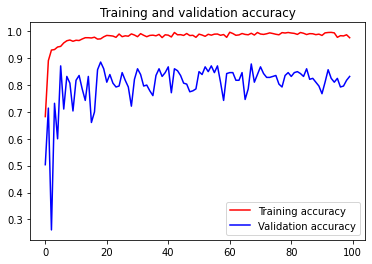

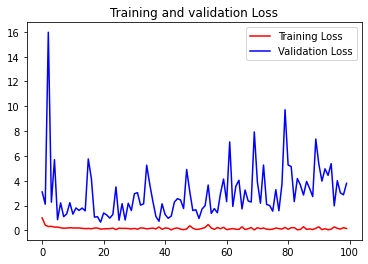

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(test_generator, steps=test_generator.n // BS + 1)

y_pred = np.argmax(Y_pred, axis=1)
print()

print('Confusion Matrix')
target_names = list(test_generator.class_indices.keys())
print(target_names)
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



Confusion Matrix
['Aster_Yellow', 'Black_Rot', 'Growth_crack', 'Healty', 'Root_knot', 'Scal_Rot']
[[46  2  1  0  4  0]
 [ 0 47  2  0  0  0]
 [ 0  3 38  1  9  0]
 [ 4  0  0 42  3  1]
 [ 0  0  2  0 42  0]
 [ 0  0  0  0  0 49]]
Classification Report
              precision    recall  f1-score   support

Aster_Yellow       0.92      0.87      0.89        53
   Black_Rot       0.90      0.96      0.93        49
Growth_crack       0.88      0.75      0.81        51
      Healty       0.98      0.84      0.90        50
   Root_knot       0.72      0.95      0.82        44
    Scal_Rot       0.98      1.00      0.99        49

    accuracy                           0.89       296
   macro avg       0.90      0.89      0.89       296
weighted avg       0.90      0.89      0.89       296

